# Graphs
> Comparing embeddings for Polblogs

Here we will compare 3 embedding methods:
1. Poincare embeddings:
    * This is an implementation of Nickel and Kiela's method from [Poincaré Embeddings for Learning Hierarchical Representations](https://arxiv.org/abs/1705.08039)
    * Can simply use `geomstats.datasets.prepare_graph_data.HyperbolicEmbedding`
2. Mixed-curvature embeddings:
    * This is taken from [Learning Mixed-Curvature Representations in Product Spaces](https://arxiv.org/abs/1806.02608)
    * Adapted code from [this Github repo](https://github.com/HazyResearch/hyperbolics)
3. Combinatorial algorithm:
    * This is taken from [Representation Tradeoffs for Hyperbolic Embeddings](https://arxiv.org/abs/1806.05337)
    * Adapted code from same repo as (2)

Not currently being explored:
* [Learning Continuous Hierarchies in the Lorentz Model of Hyperbolic Geometry](https://arxiv.org/abs/1806.03417)

In [1]:
%load_ext autoreload
%autoreload 2

In [59]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from tqdm import tqdm_notebook as tqdm

import geomstats

# Repo: https://github.com/HazyResearch/hyperbolics
from hyperbolics.utils.distortions import map_score, distortion


## Load graphs

This assumes we are using the netset convention. In particular, it assumes that a 
directory contains the following files:
* `adjacency.tsv`: TSV with columns "start_node, end_node, weight"
* `labels.tsv`: TSV with column "label", ordered by node index
* `names.tsv` (optional): TSV with column "name", ordered by node index
* `names_labels.tsv` (optional): TSV with column "name", ordered by label index

In [72]:
def dense_adjacency_matrix(adjacency_path):
    # Dense adjacency matrix: (nodes, nodes)
    adjacency = (
        pd.read_table(adjacency_path, header=None)
        .pivot(index=0, columns=1, values=2)
        .fillna(0)
        .astype(int)
    )

    # Save dense adjacency matrix
    new_path = adjacency_path.replace("/raw/", "/interim/").replace(
        ".tsv", "_dense.tsv"
    )
    os.makedirs(os.path.dirname(new_path), exist_ok=True)
    adjacency.to_csv(new_path, sep="\t", header=False, index=False)

    return adjacency


def load_graph(graph_dir, graph_type="directed", edge_type="unweighted"):
    apath = f"{graph_dir}/adjacency.tsv"
    adpath = f"{graph_dir.replace('/raw/', '/interim/')}/adjacency_dense.tsv"
    lpath = f"{graph_dir}/labels.tsv"
    npath = f"{graph_dir}/names.tsv"
    nlpath = f"{graph_dir}/names_labels.tsv"

    # Adjacency matrix: (out_node, in_node)
    adjacency = pd.read_table(apath, header=None, usecols=[0, 1])

    # Labels: (label, )
    labels = pd.read_table(lpath, header=None)

    # Label name: (label_name, )
    if os.path.exists(nlpath):
        names_labels = pd.read_table(nlpath, header=None)
    else:
        names_labels = pd.Series(labels[0].unique()).reset_index()

    # Node name: (node_name, )
    if os.path.exists(npath):
        names = pd.read_table(npath, header=None)
    else:
        names = pd.Series(np.arange(len(labels))).reset_index()

    # Networkx object
    base_graph = nx.DiGraph if graph_type == "directed" else nx.Graph
    nx_graph = nx.from_pandas_edgelist(
        adjacency, source=0, target=1, create_using=base_graph
    )
    nx_graph.add_nodes_from(names.index)

    # Geomstats Graph object
    dense_adjacency_matrix(apath)
    gs_graph = geomstats.datasets.prepare_graph_data.Graph(
        graph_matrix_path=adpath, labels_path=lpath
    )

    # Pairwise distances
    dists = nx.floyd_warshall_numpy(nx_graph)

    return {
        "adjacency": adjacency,
        "labels": labels,
        "names_labels": names_labels,
        "names": names,
        "nx_graph": nx_graph,
        "gs_graph": gs_graph,
        "dists": dists,
    }


polblogs = load_graph("data/raw/polblogs")


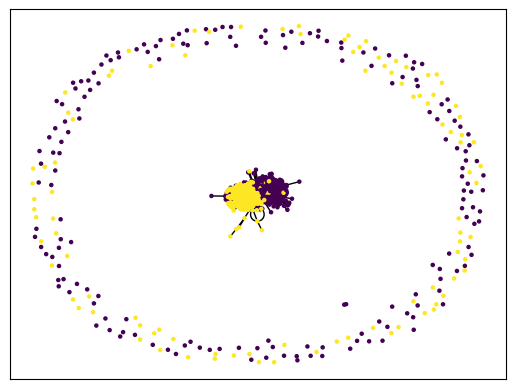

In [20]:
# Some basic plotting

nx.draw_networkx(
    polblogs["nx_graph"],
    with_labels=False,
    node_size=5,
    node_color=polblogs["labels"][0].reindex(
        polblogs["nx_graph"].nodes
    ),  # Ordering
)


1490 --> 1224


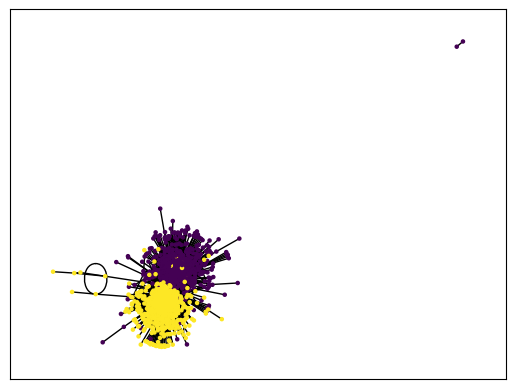

In [58]:
# Drop singleton nodes from the graph


def drop_singletons(graph):
    singletons = [n for n, d in graph.degree() if d == 0]
    graph_copy = graph.copy()
    graph_copy.remove_nodes_from(singletons)
    return graph_copy


polblogs_pruned = drop_singletons(polblogs["nx_graph"])
print(f"{len(polblogs['nx_graph'])} --> {len(polblogs_pruned)}")
nx.draw_networkx(
    polblogs_pruned,
    with_labels=False,
    node_size=5,
    node_color=polblogs["labels"][0].reindex(polblogs_pruned.nodes),
)

## Distortion and Mean average precision

**Mean average precision:** Let some node $a \in V$ have neighborhood $\mathcal{N}_a = \{b_1, b_2, \ldots, b_{deg(a)} \}$
where $a$ denotes the degree of $a$. Then we let $R_{a, b_i}$ mean the smallest set of nearest points required to retrieve the $i$-th neighbor of $a$ in our embedding space $f$. MAP is:
$$
\begin{align*}
MAP(f) &= \frac{1}{|V|} \sum_{a \in V} \frac{1}{|\mathcal{N}_a|} \sum_{i=1}^{|\mathcal{N}_a|} Precision(R_{a,b_i})\\
&= \frac{1}{|V|} \sum_{a \in V} \frac{1}{deg(a)} \sum_{i=1}^{|\mathcal{N}_a|} \frac{|\mathcal{N}_a \cap R_{a, b_i}|}{|R_{a,b_i}|}
\end{align*}
$$
Best case: $MAP(f) = 1$; not concerned with the underlying distances, only neighborhood membership.

**Distortion:** For an $n$ point embedding, the distortion is
$$
D(f) = \frac{1}{n \choose 2}\left( \frac{|d_V(f(u), f(v)) - d_U(u,v)|}{d_U(u,v)} \right)
$$

**Worst-case distortion**
$$
\begin{align}
D &= \left\{ \frac{d_V(f(u), f(v))}{d_U(u,v)} : u, v \in U, u \neq v \right\}\\
D_{wc}(f) &= \frac{\max(D)}{\min(D)}
\end{align}
$$

## Poincare embeddings (geomstats implementation)

First, we will ensure we can learn an embedding for polblogs using geomstats

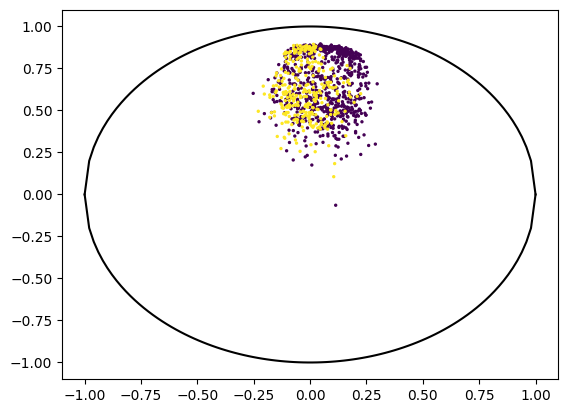

In [57]:
# Embed - geomstats

hyp_emb = HyperbolicEmbedding(
    dim=2, n_negative=4, n_context=4, lr=0.01, max_epochs=20
)
polblogs_gs_embed = hyp_emb.embed(polblogs["gs_graph"])

# Plot embeddings
plt.scatter(
    polblogs_gs_embed[:, 0],
    polblogs_gs_embed[:, 1],
    c=polblogs["labels"].reindex(polblogs["gs_graph"].edges.keys()),
    s=2,
)
# Plot poincare disk
_x = np.linspace(-1, 1, 100)
_y = np.sqrt(1 - _x ** 2)
plt.plot(_x, _y, c="black")
plt.plot(_x, -_y, c="black")
